Here, you develop the exact spatial derivative operator and its unit test.

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 64
refRatio = 2
CFL = np.sqrt(0.5)
nt = 128
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'CD'
RK = 4
order = 2

L = 1e-3
locs = []#x_1]
epsilons_r = [1]#, 11.68]
mus_r = [1]#, 0.99837]

In [3]:
if (RK == 1):
    TimeIntegratorFunc = ST.ForwardEuler
else:
    if (RK == 2):
        TimeIntegratorFunc = ST.MidpointMeth
    else:
        TimeIntegratorFunc = ST.RK4

if (deriv == 'U'):
    # DiffMatFunc = OT.Upwind1D
    DiffFunc = TT.Upwind#ST.Upwind
else:
    # DiffMatFunc = OT.CenterDiff1D
    DiffFunc = TT.CenterDiff#ST.CenterDiff

In [4]:
def GaussParams(x_0 = 0., x_1 = 1., errOrd = 14):
    mu = (x_0 + x_1) / 2.
    sigma = abs((x_1 - x_0) / np.sqrt(8 * errOrd * log(10)))
    return sigma, mu

In [5]:
omega = BT.Grid(nh)
finehalf = list(np.arange(int(nh / refRatio)))# + int(nh / refRatio))
omega.AddPatch(refRatio, finehalf)
degFreed = omega.degFreed
nh_min = omega.nh_min # GOT IT
nh_max = omega.nh_max # GOT IT

omegaF = BT.Grid(nh_max) # GOT IT
omegaC = BT.Grid(nh_min) # GOT IT

In [6]:

physics = BT.PhysProperties(omega, epsilons_r, mus_r, locs, L) # GOT IT
cVec = physics.cVec # GOT IT
cMat = physics.cMat # GOT IT

physicsC = BT.PhysProperties(omegaC, epsilons_r, mus_r, locs, L) # GOT IT
cVecC = physicsC.cVec # GOT IT
cMatC = physicsC.cMat # GOT IT

physicsF = BT.PhysProperties(omegaF, epsilons_r, mus_r, locs, L) # GOT IT
cVecF = physicsF.cVec # GOT IT
cMatF = physicsF.cMat # GOT IT
print(cMatC)
c = max(cVec)
print(c)

[[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

In [7]:
# c = ConvertParams(permitivity, permeability, L)
t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt) # GOT IT
mu, sigma = GaussParams(x_0, x_1) # DON'T NEED
waves = WT.MakeWaves(omega) # GOT IT
nullspace = OT.FindNullspace(omega, waves, Hans = Hans) # GOT IT
restrictOp = GTT.CoarsenOp(omega) # GOT IT
print('sig:', sigma, 'mu:', mu)

wavesF = WT.MakeWaves(omegaF) # GOT IT
wavesC = WT.MakeWaves(omegaC) # GOT IT

derivMat = TT.ExactSpatOp(omega) # GOT IT
print(np.shape(cMatF))
print(np.shape(derivMat))
spatOp = -cMatF @ derivMat # GOT IT
timePropOp = LA2.expm(t * spatOp) # GOT IT

derivMatC = TT.ExactSpatOp(omegaC) # GOT IT
spatOpC = -cMatC @ derivMatC # GOT IT
timePropOpC = LA2.expm(t * spatOpC) # GOT IT


sig: 0.25 mu: 0.03113530673812129
[[  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

In [8]:
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
# PT.PlotWaves(omega, waves = waves)
# t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
timePropOp = LA2.expm(t * spatOp)
print(sigma, mu)

0.25 0.03113530673812129


In [9]:
# Find initial waveform on coarse and fine grids.
# For Gaussian:
waveInitC = WFT.Gauss(omegaC, sigma, mu) # GOT IT
waveInitF = WFT.Gauss(omegaF, sigma, mu) # GOT IT

# Find initial waveform on AMR grid.
waveInitAMR = restrictOp @ waveInitF # GOT IT

# Find Fourier coefficients for initial condition on coarse and fine grids.
FCoefsC = FFTT.FourierCoefs(omegaC, wavesC, waveInitC) # GOT IT
FCoefsF = FFTT.FourierCoefs(omegaF, wavesF, waveInitF) # GOT IT

# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(omega, waves @ nullspace, waveInitAMR) # GOT IT
# print('initial Coarse:')
# print(np.round(FCoefsC, 14))
# print('initial Fine:')
# print(np.round(FCoefsF, 14))
# print('initial AMR:')
# print(np.round(FCoefsAMR, 14))
# print('')

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = timePropOpC @ FCoefsC # GOT IT
FCoefsPropF = timePropOp @ FCoefsF # GOT IT

# Find propagated waveform on AMR grid.
wavePropAMR = restrictOp @ wavesF @ FCoefsPropF # GOT IT

# Find propagated coefficients on AMR grid.
FCoefsPropAMR = FFTT.FourierCoefs(omega, waves @ nullspace, wavePropAMR)#[:degFreed]) # GOT IT
# FCoefsPropAMR = FFTT.FourierCoefs(omega, waves @ nullspace, wavePropAMR[degFreed:])

print(FCoefsPropC)
print(FCoefsPropF)
print(np.round(FCoefsPropAMR, 14))

# Find theoretical propagated coefficients on coarse, fine, and AMR grid.
# (THIS CAN ONLY BE USED IF MATERIAL IS UNIFORM!)
# FCoefsPropCTh = FFTT.PropRestrictWaves(omegaC, waveInitC, c * t)
# FCoefsPropFTh = FFTT.PropRestrictWaves(omegaF, waveInitF, c * t)
# FCoefsPropAMRTh = FFTT.PropRestrictWaves(omega, waveInitF, c * t)
# (THIS CAN BE USED GENERALLY.)
# wavePropFTh = WFT.Gauss(omegaF, sigma, mu + (c * t))
# wavePropCTh = WFT.Gauss(omegaC, sigma, mu + (c * t))
# wavePropAMRTh = restrictOp @ wavePropFTh
# FCoefsPropCTh = FFTT.FourierCoefs(omegaC, wavesC, wavePropCTh)
# FCoefsPropFTh = FFTT.FourierCoefs(omegaF, wavesF, wavePropFTh)
# FCoefsPropAMRTh = FFTT.FourierCoefs(omega, waves @ nullspace, wavePropAMRTh)

solverCoefsC = TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
solverCoefsF = TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
solverCoefsAMR = TimeIntegratorFunc(omega, waves @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)

# print('')
# print(np.round(FCoefsPropCTh, 14))
# print(np.round(FCoefsPropFTh, 14))
# print(np.round(FCoefsPropAMRTh, 14))

allCoefsC = PT.Load(FCoefsC, FCoefsPropC, solverCoefsC)#, FCoefsPropCTh)
allCoefsF = PT.Load(FCoefsF, FCoefsPropF, solverCoefsF)#, FCoefsPropFTh)
allCoefsAMR = PT.Load(FCoefsAMR, FCoefsPropAMR, solverCoefsAMR)#, FCoefsPropAMRTh)

labels = ['Initial Wave', 'Exact Derivative Propagated Wave', 'RK Propagated Wave']#, 'Rotation Matrix Propagated Wave']


[ 0.34435019 -0.27047159  0.34603213 -0.16157676 -0.0899558   0.07837531 -0.07941209  0.04035245  0.07151085 -0.06362412  0.01554173  0.00180187 -0.05474424  0.0451209   0.01418051 -0.02275626  0.03507091 -0.02493767 -0.02817672  0.0308792  -0.01506894  0.00579984  0.03122052 -0.02953632 -0.00256188  0.00974878 -0.02616774  0.02147098  0.01554478 -0.01979413  0.01581724 -0.00958675 -0.02240781  0.02336733 -0.0031593  -0.00309739  0.02272556 -0.02060471 -0.00884009  0.01376264 -0.01719137  0.01272878  0.01760768 -0.02017702  0.00750667 -0.00184888 -0.02134003  0.02103961  0.00390069 -0.00939331  0.01929534 -0.01620368 -0.01429128  0.01828384 -0.01193494  0.00672717  0.02110244 -0.0225348   0.00087693  0.00527267 -0.02243718  0.0207443   0.01134643  0.01217426]
[ 3.44350195e-01 -2.70420915e-01  3.45848712e-01 -1.61249562e-01 -8.97600658e-02  7.79603671e-02 -7.90160113e-02  3.99892213e-02  7.08340717e-02 -6.26826747e-02  1.53282140e-02  1.74762797e-03 -5.35793336e-02  4.38175063e-02  1.37

In [10]:
def MakeWaveform(omega, waveFunc, *args):
    waveform = waveFunc(omega, *args)
    return waveform


In [11]:
# Unpropagated:
# You already thoroughly tested Fourier Transform in ResidualsUnitTest.

# Propagated:
# You tested rotation matrix in ResidualsUnitTest.

In [19]:
# [THIS FUNCTION IS NOT SET UP TO HANDLE ANYTHING BUT THE HANSLESS NULLSPACE SELECTION MATRIX!]

def TestResults(omegaAMR, physicsAMR, nt, CFL, RK, deriv, order, waveFunc, *argsW):
    
    TimeIntegratorFunc, DiffFunc = TT.SolverSwitch(deriv, RK)
    
    # Unpack attributes from omegaAMR.
    nh_min = omegaAMR.nh_min
    nh_max = omegaAMR.nh_max
    
    # Create grid objects for uniform coarse and fine grid.
    omegaC = BT.Grid(nh_min)
    omegaF = BT.Grid(nh_max)
    
    # Unpack attributes from physicsAMR.
    epsilons_r = physicsAMR.epsilons_r
    mus_r = physicsAMR.mus_r
    L = physicsAMR.L
    locs = physicsAMR.locs
    cVec = physicsAMR.cVec
    cMat = physicsAMR.cMat
    
    # Create physics objects for uniform coarse and fine grid.
    physicsC = BT.PhysProperties(omegaC, epsilons_r, mus_r, locs, L)
    physicsF = BT.PhysProperties(omegaF, epsilons_r, mus_r, locs, L)
    
    # Unpack attributes from physicsC and physicsF.
    cVecC = physicsC.cVec
    cMatC = physicsC.cMat
    cVecF = physicsF.cVec
    cMatF = physicsF.cMat
    
    # Find Fourier matrices for coarse, fine, and AMR grid.
    wavesAMR = WT.MakeWaves(omegaAMR)
    wavesC = WT.MakeWaves(omegaC)
    wavesF = WT.MakeWaves(omegaF)
    
    # Find nullspace and restriction operators for given AMR grid.
    nullspace = OT.FindNullspace(omegaAMR, wavesAMR)
    restrictOp = GTT.CoarsenOp(omegaAMR)
    
    # Find time elapsed and timesteps by which to propagate solution.
    # [THIS MIGHT NEED TO BE CHANGED TO INCLUDE DIFFERENT VALUES FOR COARSE AND FINE GRIDS!] (But also maybe not.)
    t, nt = ST.CalcTime(omegaAMR, CFL, cMat, nt = nt)
    
    # Create exact Fourier derivative operators for coarse, fine, and AMR grid.
    derivMatC = TT.ExactSpatOp(omegaC)
    derivMat = TT.ExactSpatOp(omegaAMR) # Works on fine grid to produce results on AMR grid!
    
    # Create exact spatial operators for coarse, fine, and AMR grid.
    spatOpC = -cMatC @ derivMatC
    spatOp = -cMatF @ derivMat # Works on fine grid to produce results on AMR grid!
    
    # Create matrix exponential time integration operator for coarse, fine, and AMR grid.
    timePropOpC = LA2.expm(t * spatOpC)
    timePropOp = LA2.expm(t * spatOp) # Works on fine grid to produce results on AMR grid!
    
    # Find initial waveform on coarse, fine, and AMR grid.
    waveInitC = waveFunc(omegaC, *argsW)
    waveInitF = waveFunc(omegaF, *argsW)
    waveInitAMR = restrictOp @ waveInitF
    
    # Find Fourier coefficients for initial condition on coarse, fine, and AMR grid.
    FCoefsC = FFTT.FourierCoefs(omegaC, wavesC, waveInitC)
    FCoefsF = FFTT.FourierCoefs(omegaF, wavesF, waveInitF)
    FCoefsAMR = FFTT.FourierCoefs(omegaAMR, waves @ nullspace, waveInitAMR)
    
    # Find exact propagated coeficients on coarse and fine grid using exact Fourier derivative matrix exponential.
    # [THIS BLOCK MIGHT BE MADE MODULAR!]
    FCoefsPropC = timePropOpC @ FCoefsC
    FCoefsPropF = timePropOp @ FCoefsF

    # Find propagated waveform on AMR grid.
    wavePropAMR = restrictOp @ wavesF @ FCoefsPropF
    
    # Find exact propagated coefficients on AMR grid.
    FCoefsPropAMR = FFTT.FourierCoefs(omega, waves @ nullspace, wavePropAMR)
    
    # Find propagated coeficients on coarse, fine, and AMR grid using RK solver.
    solverCoefsC = TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
    solverCoefsF = TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
    solverCoefsAMR = TimeIntegratorFunc(omega, waves @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)
    
    # Load initial and propagated coeficients for coarse, fine, and AMR grid into condensed arrays for plotting.
    allCoefsC = PT.Load(FCoefsC, FCoefsPropC, solverCoefsC)
    allCoefsF = PT.Load(FCoefsF, FCoefsPropF, solverCoefsF)
    allCoefsAMR = PT.Load(FCoefsAMR, FCoefsPropAMR, solverCoefsAMR)
    
    # Create labels for plots.
    labels = ['Initial Wave', 'Exact Derivative Propagated Wave', 'RK Propagated Wave']
    
    PT.PlotMixedWave(omegaC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, title = 'Coarse-Grid Mode Propagation')#, saveName = 'Coarse', dpi = 300)
    PT.PlotMixedWave(omegaF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True)#, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
    PT.PlotMixedWave(omega, waves = waves, FCoefs = nullspace @ allCoefsAMR, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)

    
    # INCLUDE IF STATEMENTS WHICH WOULD ADDITIONALLY CAUSE TESTRESULTS() TO COMPUTE ROTATION MATRIX AND DIRECT
    # PROPAGATED WAVEFORM CALCULATION IF C IS UNIFORM!
    
    # OUTPUT PLOTS TO SCREEN.
    
    # OUTPUT NORM VALUES TO SCREEN.
    
    # FIGURE OUT CONVERGENCE TEST.
    # ks, error = AmpError(omega, theoreticalIn, actualIn, printOut = True)
    return

In [ ]:
args = GaussParams(x_0, x_1) # sigma, mu
# print(type(args))
TestResults(omega, physics, nt, CFL, RK, deriv, order, WFT.Gauss, *args)
# print(blah)
# print(waveInitC)

[[  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  -2.   0.

Are you *sure* your labels are ordered correctly?


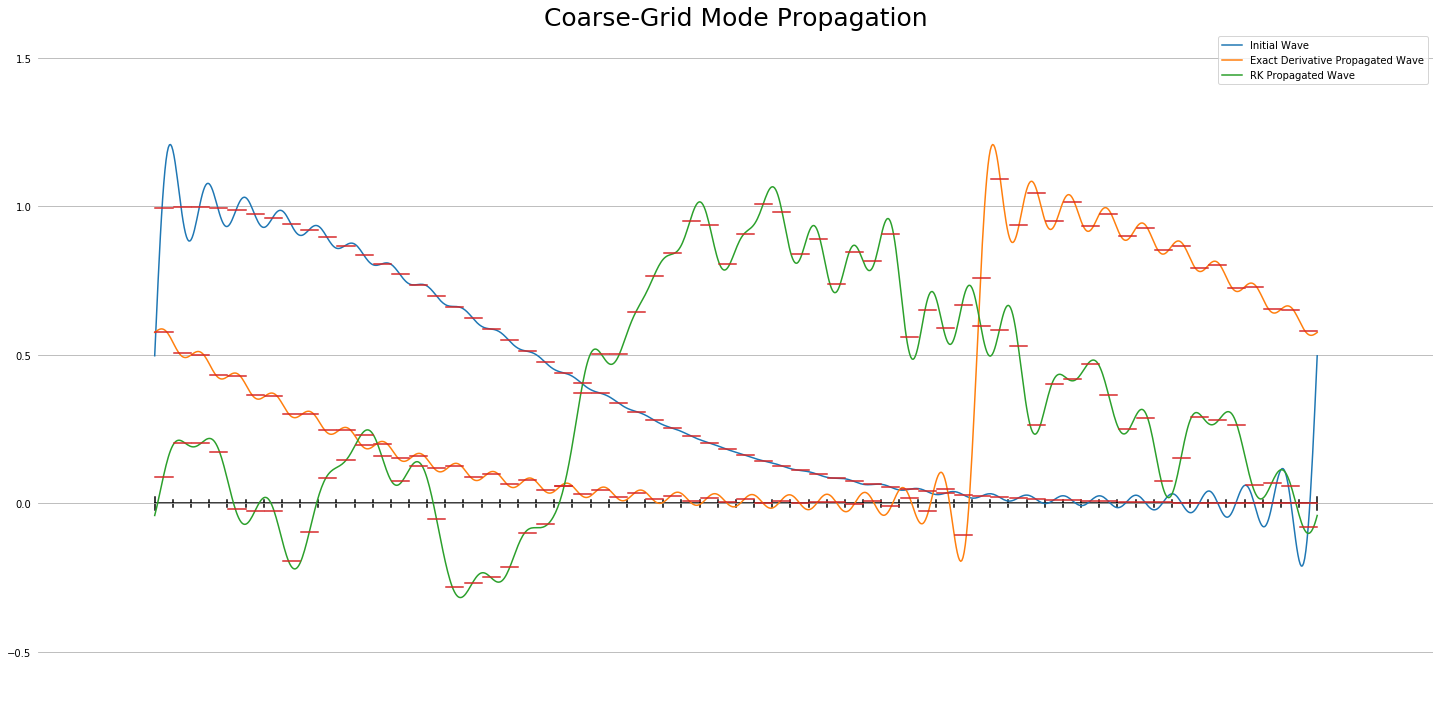

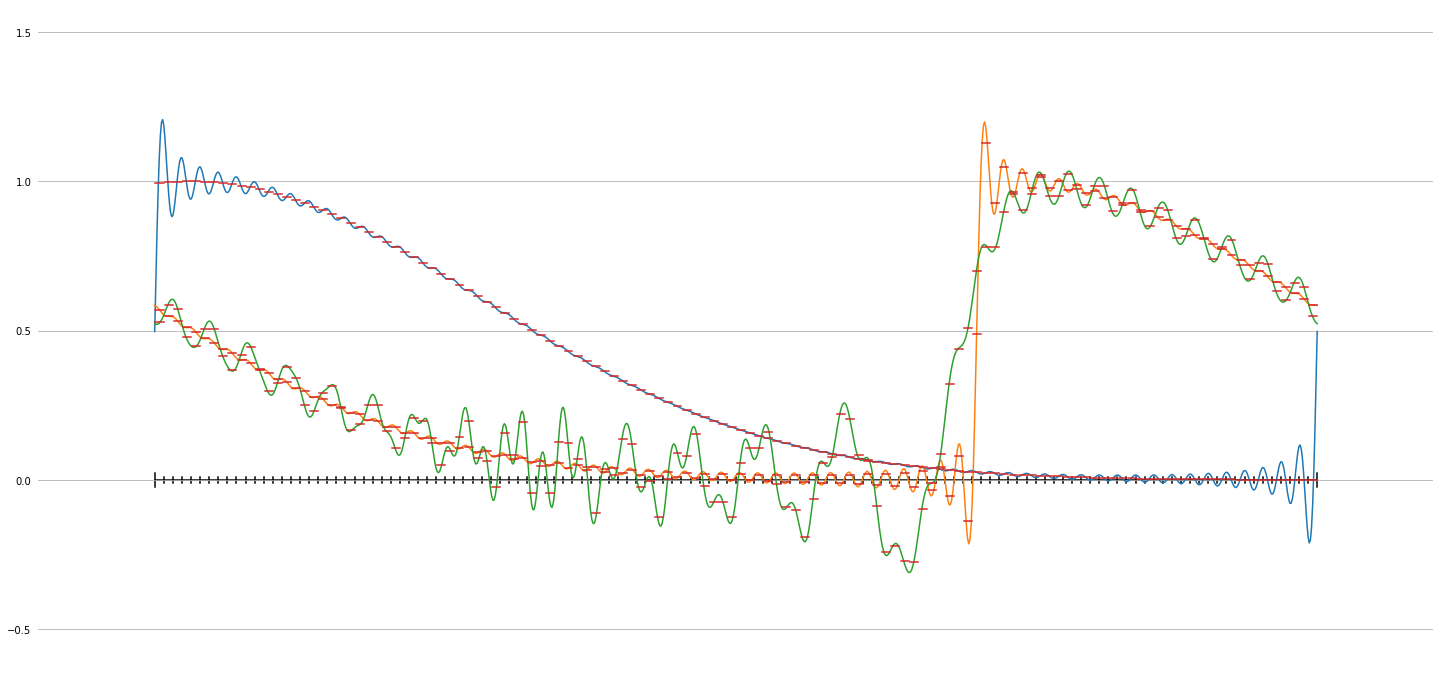

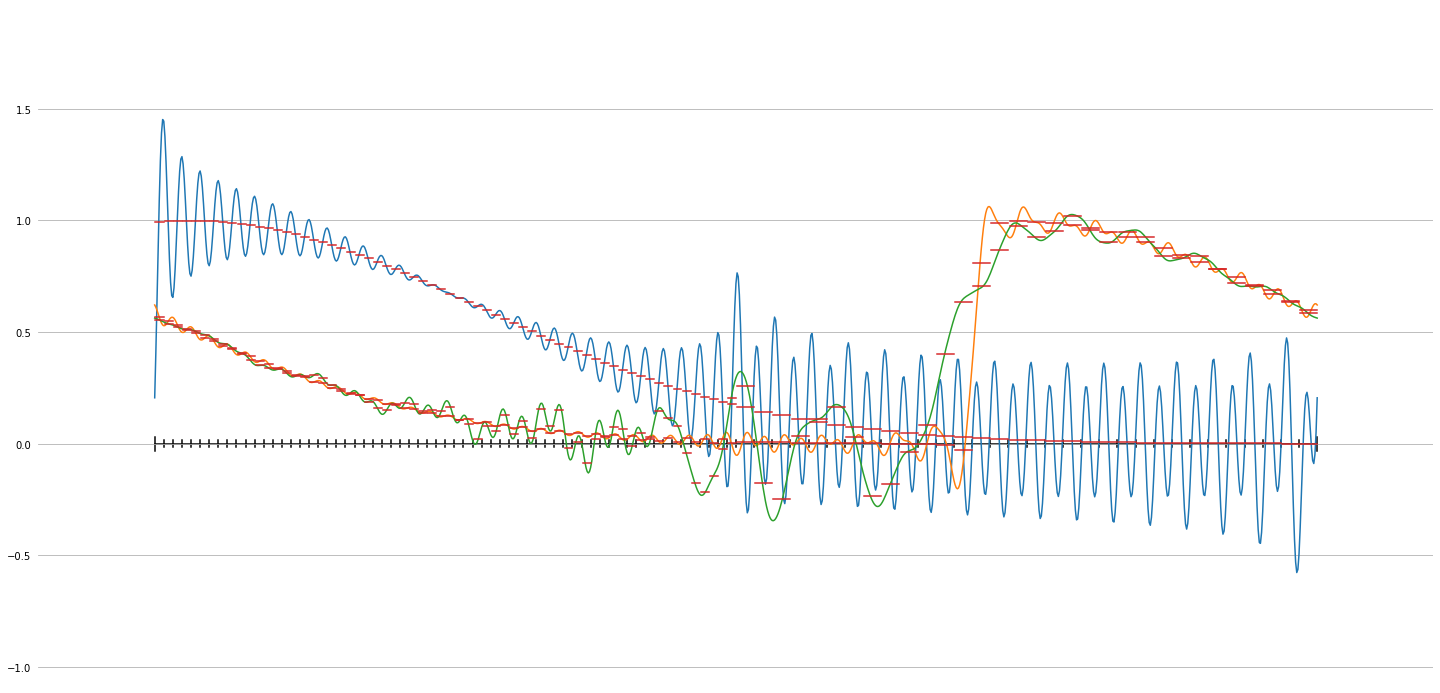

In [14]:
PT.PlotMixedWave(omegaC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, title = 'Coarse-Grid Mode Propagation')#, saveName = 'Coarse', dpi = 300)
PT.PlotMixedWave(omegaF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True)#, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
PT.PlotMixedWave(omega, waves = waves, FCoefs = nullspace @ allCoefsAMR, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


In [15]:
# For Gaussian:
waveInitF = WFT.Gauss(omegaF, sigma, mu)
waveInitC = WFT.Gauss(omegaC, sigma, mu)
FCoefsC = FFTT.FourierCoefs(omegaC, wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(omegaF, wavesF, waveInitF)

# Find initial waveform on coarse, fine, and AMR grids.
waveInitC = wavesC @ FCoefsC
waveInitF = wavesF @ FCoefsF
waveInitAMR = restrictOp @ waveInitF

# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(omega, waves @ nullspace, waveInitAMR)
# print('initial Coarse:')
# print(np.round(FCoefsC, 14))
# print('initial Fine:')
# print(np.round(FCoefsF, 14))
# print('initial AMR:')
# print(np.round(FCoefsAMR, 14))
# print('')

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = timePropOpC @ FCoefsC
FCoefsPropF = timePropOp @ FCoefsF

# Find propagated waveform on AMR grid.
wavePropAMR = restrictOp @ wavesF @ FCoefsPropF

# Find propagated coefficients on AMR grid.
FCoefsPropAMR = FFTT.FourierCoefs(omega, waves @ nullspace, wavePropAMR)

print(FCoefsPropC)
print(FCoefsPropF)
print(np.round(FCoefsPropAMR, 14))

# Find theoretical propagated coefficients on coarse, fine, and AMR grid.
# (THIS CAN ONLY BE USED IF MATERIAL IS UNIFORM!)
# FCoefsPropCTh = FFTT.PropRestrictWaves(omegaC, waveInitC, c * t)
# FCoefsPropFTh = FFTT.PropRestrictWaves(omegaF, waveInitF, c * t)
# FCoefsPropAMRTh = FFTT.PropRestrictWaves(omega, waveInitF, c * t)
# (THIS CAN BE USED GENERALLY.)
wavePropFTh = WFT.Gauss(omegaF, sigma, mu + (c * t))
wavePropCTh = WFT.Gauss(omegaC, sigma, mu + (c * t))
wavePropAMRTh = restrictOp @ wavePropFTh
FCoefsPropCTh = FFTT.FourierCoefs(omegaC, wavesC, wavePropCTh)
FCoefsPropFTh = FFTT.FourierCoefs(omegaF, wavesF, wavePropFTh)
FCoefsPropAMRTh = FFTT.FourierCoefs(omega, waves @ nullspace, wavePropAMRTh)


solverCoefsC = TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
solverCoefsF = TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
solverCoefsAMR = TimeIntegratorFunc(omega, waves @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order + 1)

# print('')
# print(np.round(FCoefsPropCTh, 14))
# print(np.round(FCoefsPropFTh, 14))
# print(np.round(FCoefsPropAMRTh, 14))

allCoefsC = PT.Load(FCoefsC, FCoefsPropCTh, FCoefsPropC, solverCoefsC)#
allCoefsF = PT.Load(FCoefsF, FCoefsPropFTh, FCoefsPropF, solverCoefsF)#
allCoefsAMR1 = PT.Load(FCoefsAMR, FCoefsPropAMRTh, FCoefsPropAMR, solverCoefsAMR)#

labels = ['Initial Wave', 'Theoretical Propagated Wave', 'Exact Derivative Matrix Exponential Propagated Wave', 'RK Propagated Wave']#, 'Rotation Matrix Propagated Wave']


[ 0.34435019 -0.27047159  0.34603213 -0.16157676 -0.0899558   0.07837531 -0.07941209  0.04035245  0.07151085 -0.06362412  0.01554173  0.00180187 -0.05474424  0.0451209   0.01418051 -0.02275626  0.03507091 -0.02493767 -0.02817672  0.0308792  -0.01506894  0.00579984  0.03122052 -0.02953632 -0.00256188  0.00974878 -0.02616774  0.02147098  0.01554478 -0.01979413  0.01581724 -0.00958675 -0.02240781  0.02336733 -0.0031593  -0.00309739  0.02272556 -0.02060471 -0.00884009  0.01376264 -0.01719137  0.01272878  0.01760768 -0.02017702  0.00750667 -0.00184888 -0.02134003  0.02103961  0.00390069 -0.00939331  0.01929534 -0.01620368 -0.01429128  0.01828384 -0.01193494  0.00672717  0.02110244 -0.0225348   0.00087693  0.00527267 -0.02243718  0.0207443   0.01134643  0.01217426]
[ 3.44350195e-01 -2.70420915e-01  3.45848712e-01 -1.61249562e-01 -8.97600658e-02  7.79603671e-02 -7.90160113e-02  3.99892213e-02  7.08340717e-02 -6.26826747e-02  1.53282140e-02  1.74762797e-03 -5.35793336e-02  4.38175063e-02  1.37

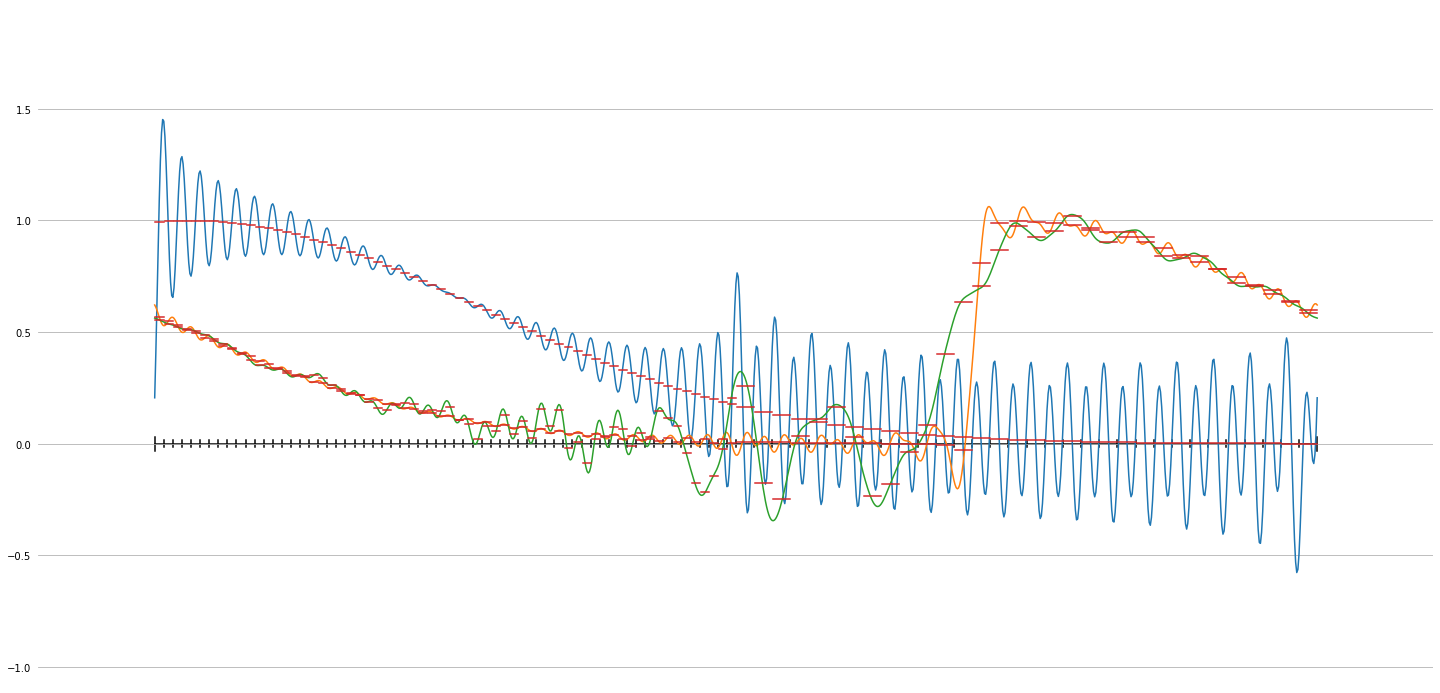

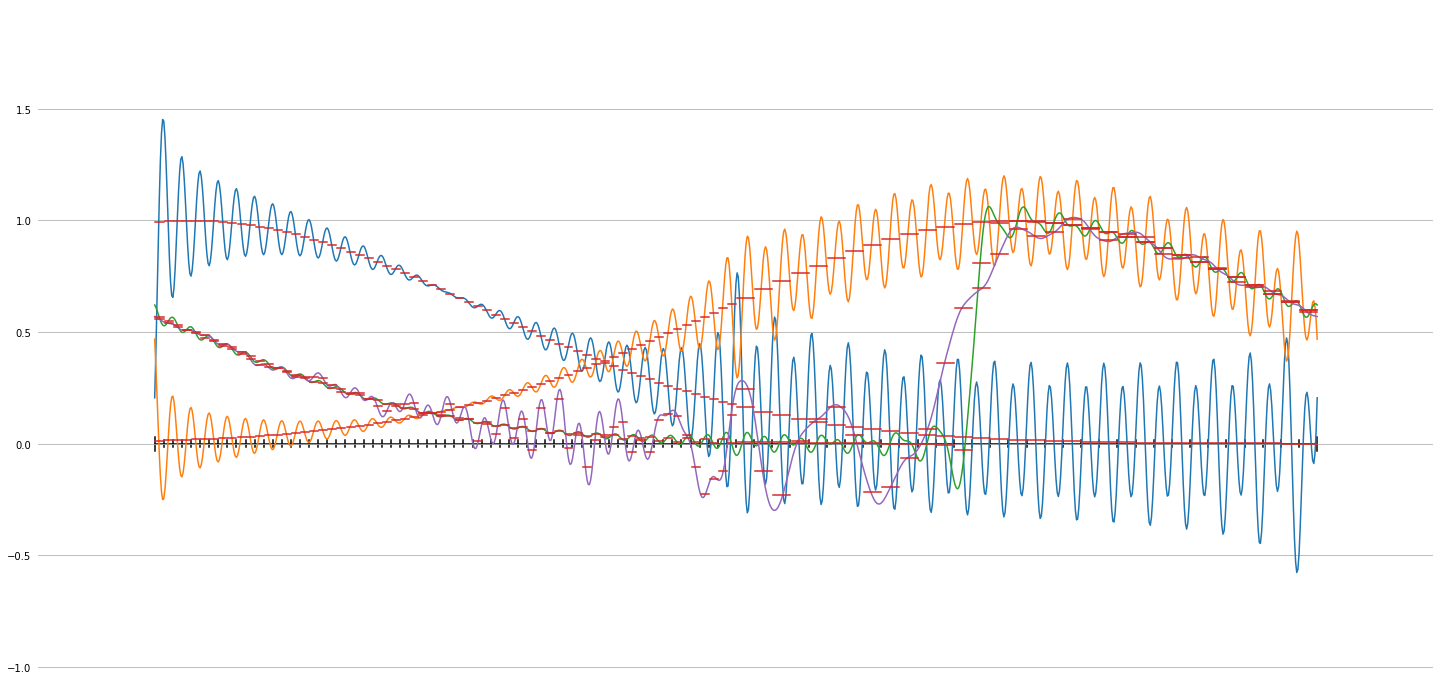

In [16]:
PT.PlotMixedWave(omega, waves = waves, FCoefs = nullspace @ allCoefsAMR, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)
PT.PlotMixedWave(omega, waves = waves, FCoefs = nullspace @ allCoefsAMR1, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


In [17]:
# Notes for Hans:
#
# If the resolution is too low, there isn't sufficient high-frequency content to represent the gaussian.
# Sparse function needs to be developed for upwind and center-diffference of arbitrary-order polynomial interpolation.
# I see that I can't use the rotation matrix to propagate the matrices. I'm pretty sure that my Fourier-propagated logic is wrong, though.
# 2nd-order polynomial interp is working BETTER THAN 3rd-order for RK4 center diff.


In [18]:
# Notes for Sasha:
#
# Make residuals test of Gaussian (first unpropagated, then propagated) to assess its validity.
